In [51]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Solar energy prediction - Project/Datasets/Out/full.csv'

In [4]:
df = pd.read_csv(file_path, parse_dates= True, index_col= 0)
df.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2)
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24


In [5]:
cols_to_transform = ['air_temp', 'precip_depth_per_hour', 'station_pressure_rate', 'Vitesse du vent à 100m (m/s)', 'Rayonnement solaire global (W/m2)']

In [6]:
#Delete unnecessary columns, then convert the "Date" column to time data type, and set the "Date" column as an index
df.drop(df[cols_to_transform], axis=1, inplace=True)
df.index = pd.to_datetime(df.index)
df = df.set_index(df.index, drop=True)
print(df.head(10))

                     Solaire (MW)
2017-01-01 01:00:00             0
2017-01-01 04:00:00             0
2017-01-01 07:00:00             0
2017-01-01 10:00:00            15
2017-01-01 13:00:00            22
2017-01-01 16:00:00             1
2017-01-01 19:00:00             0
2017-01-01 22:00:00             0
2017-01-02 01:00:00             0
2017-01-02 04:00:00             0


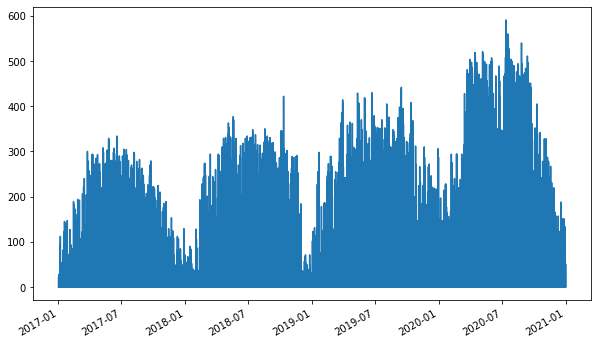

In [7]:
#Draw a time series line graph
plt.figure(figsize=(10, 6))
df['Solaire (MW)'].plot()
plt.show()

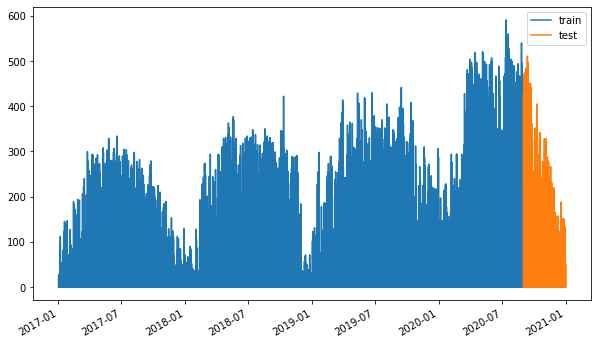

In [8]:
#Split the data into training set and test set by date "2018–01–01", that is, the data before this date is the training data, and the data after this date is the test data. We will visualize it again.
split_date = pd.Timestamp('2020-09-01')
df = df['Solaire (MW)']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

## **Simple artificial neural network for time series forecasting**

The activation function is the linear rectification function Relu (Rectified Linear Unit, also known as the corrected linear unit).

The loss function is mean_squared_error, and the optimizer is Adam.

When it is detected that the loss stops improving, the training ends.

Patience = 2, which means that the result has not improved after several cycles, and the training can be ended at this time.

The training time of the artificial neural network is 100 cycles, and each time 96 samples are used for training.

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

#Get training and test data, here is a period of lag
X_train = train_sc[:-1]
y_train = train_sc[1:]
X_test = test_sc[:-1]
y_test = test_sc[1:]

In [38]:
test.shape

(976, 1)

In [10]:
nn_model = Sequential()
nn_model.add(Dense(96, input_dim=1, activation='relu'))
nn_model.add(Dense(1))
nn_model.compile(loss='mse', optimizer='adam')
#early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=96, verbose=0, shuffle=False)#, callbacks=[early_stop])

In [11]:
y_pred_test_nn = nn_model.predict(X_test)
y_train_pred_nn = nn_model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))

The R2 score on the Train set is:	0.419
The R2 score on the Test set is:	0.326


## **LSTM**

The construction and model compilation of LSTM networks are similar to artificial neural networks.

LSTM has a visible layer, which has 1 input.

The hidden layer has 100 LSTM neurons.

The output layer performs single-value prediction.

LSTM neurons are activated using the Relu function.

The training time of LSTM is 100 cycles, and each time 96 sample is used for training.

In [12]:
X_train_lmse = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lmse = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [13]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
#early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=96, verbose=0, shuffle=False)#, callbacks=[early_stop])

In [14]:
y_pred_test_lstm = lstm_model.predict(X_test_lmse)
y_train_pred_lstm = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.433
The R2 score on the Test set is:	0.346


## **Compare models**

We compared the test MSE of the two models

In [16]:
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=96)
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=96)
print('NN: %f'%nn_test_mse)
print('LSTM: %f'%lstm_test_mse)

11/11 [==============================] - 1s 2ms/step - loss: 0.0211
NN: 0.021718
LSTM: 0.021094


## **Make predictions**

In [17]:
#Make predictions
nn_y_pred_test = nn_model.predict(X_test)
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

In [ ]:
inv_nn_y_pred_test = np.concatenate((nn_y_pred_test, X_test[:, 1:]), axis=1)
inv_nn_y_pred_test = scaler.inverse_transform(inv_nn_y_pred_test)
inv_nn_y_pred_test = inv_nn_y_pred_test[:,0]

In [28]:
inv_y_pred_test_lstm = np.concatenate((y_pred_test_lstm, X_test[:, 1:]), axis=1)
inv_y_pred_test_lstm = scaler.inverse_transform(inv_y_pred_test_lstm)
inv_y_pred_test_lstm = inv_y_pred_test_lstm[:,0]

In [ ]:
inv_y_pred_test_lstm

In [20]:
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

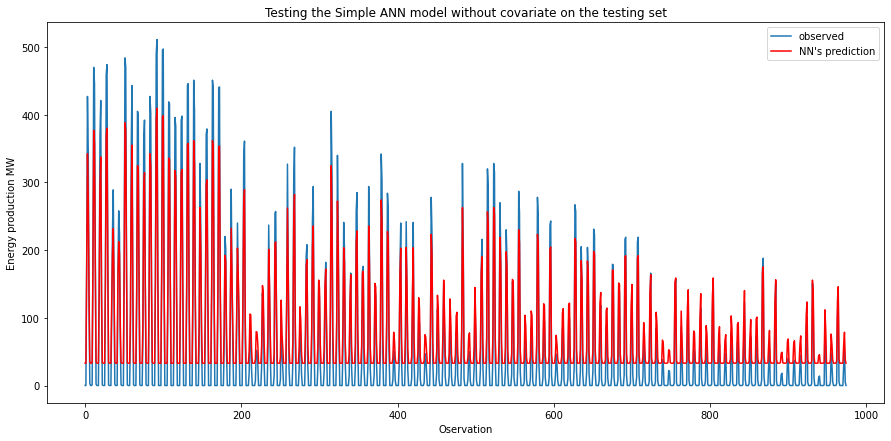

In [50]:
plt.figure(figsize = (15,7))
_ = plt.plot(test[:-1], label='observed')

# plot your mean predictions
_ = plt.plot(inv_nn_y_pred_test, 'r', label='NN\'s prediction')

# set labels, legends and show plot
_ = plt.xlabel('Oservation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the Simple ANN model without covariate on the testing set')

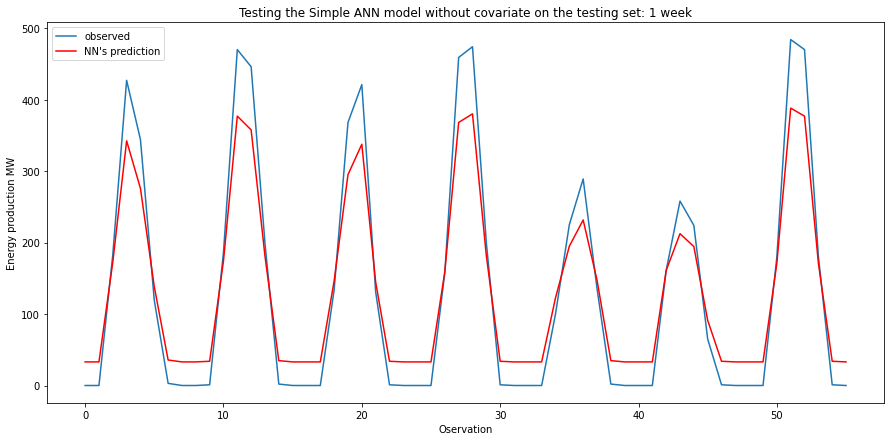

In [52]:
plt.figure(figsize = (15,7))
_ = plt.plot(test[:56], label='observed')

# plot your mean predictions
_ = plt.plot(inv_nn_y_pred_test[:56], 'r', label='NN\'s prediction')

# set labels, legends and show plot
_ = plt.xlabel('Oservation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the Simple ANN model without covariate on the testing set: 1 week')

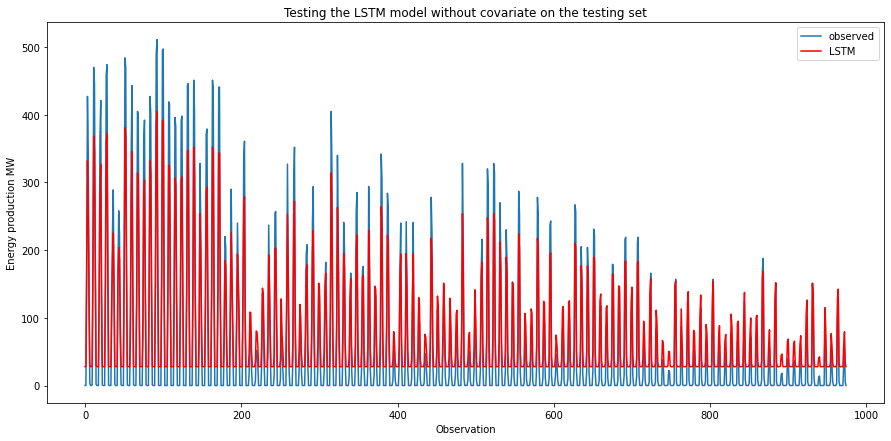

In [46]:
plt.figure(figsize = (15,7))
_ = plt.plot(test[:-1], label='observed')

# plot your mean predictions
_ = plt.plot(inv_y_pred_test_lstm, 'r', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Observation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model without covariate on the testing set')

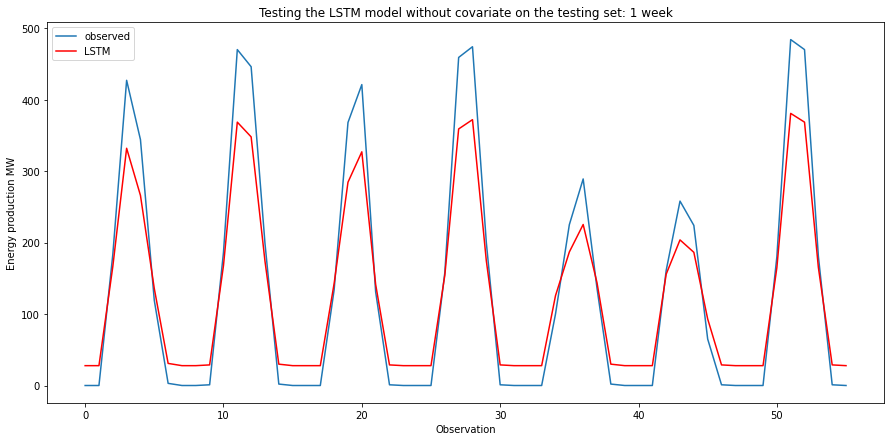

In [47]:
plt.figure(figsize = (15,7))
_ = plt.plot(test[:56], label='observed')

# plot your mean predictions
_ = plt.plot(inv_y_pred_test_lstm[:56], 'r', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Observation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model without covariate on the testing set: 1 week')

In [25]:
def error_metrics(y_pred, y_truth, model_name = None):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error). 
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    model_name: name of the model used for predictions
    
    The function will print the RMSE, R2, MAE error metrics for the model_name
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

In [55]:
error_metrics(inv_nn_y_pred_test[:56], test[:56], model_name = 'ANN without covariate: 1 week')


Error metrics for model ANN without covariate: 1 week
RMSE or Root mean squared error: 45.56
Variance score: 0.92
Mean Absolute Error: 38.11


In [53]:
error_metrics(inv_nn_y_pred_test, test[:-1], model_name = 'ANN without covariate')


Error metrics for model ANN without covariate
RMSE or Root mean squared error: 35.40
Variance score: 0.89
Mean Absolute Error: 32.59


In [56]:
error_metrics(inv_y_pred_test_lstm[:56], test[:56], model_name = 'LSTM without covariate: 1 week')


Error metrics for model LSTM without covariate: 1 week
RMSE or Root mean squared error: 47.84
Variance score: 0.92
Mean Absolute Error: 38.43


In [54]:
error_metrics(inv_y_pred_test_lstm, test[:-1], model_name = 'LSTM without covariate')


Error metrics for model LSTM without covariate
RMSE or Root mean squared error: 34.47
Variance score: 0.89
Mean Absolute Error: 30.47
